In [1]:
from ucb import NeuralUCB, LinUCB
import joblib
import pandas as pd

In [2]:
offline_placebo_model = joblib.load("rewarder/placebo_ohs6_predictor.pkl")
offline_treatment_model = joblib.load("rewarder/treat_ohs6_predictor.pkl")

In [3]:
df = pd.read_csv('action_reward_context_combined_processed.csv')

In [4]:
df.head()

,ohs6,treatment,pretrialexp,phase,age,randdelay,sbprand,dbprand,weight,glucose,...,visuospat_rand_Unknown,visuospat_rand_Yes,brainstemsigns_rand_Unknown,brainstemsigns_rand_Yes,otherdeficit_rand_Unknown,otherdeficit_rand_Yes,stroketype_Other,stroketype_PACI,stroketype_POCI,stroketype_TACI
0,0.333333,0,-1.234669,0.295828,1.246717,-1.656541,0.637048,0.721876,-0.298921,-0.512456,...,True,False,False,False,False,False,False,False,False,True
1,0.166667,0,-1.234669,0.295828,-0.097911,0.974224,-1.481019,-0.854515,-0.165178,-0.512456,...,False,True,False,False,False,False,False,True,False,False
2,0.166667,1,0.809606,0.295828,-1.284347,0.360833,-1.142129,-0.580360,-0.432665,-0.918008,...,False,True,False,False,False,False,False,False,False,True
3,0.500000,1,-1.234669,0.295828,0.930334,-1.615648,0.933578,0.516260,-1.168254,-0.106904,...,False,False,False,False,False,False,False,True,False,False
4,1.000000,1,0.809606,0.295828,0.613951,-0.402498,1.060662,1.201647,-0.499536,-0.512456,...,False,True,False,False,False,False,False,False,False,True


In [5]:
import pandas as pd

context = df.drop(columns=['ohs6', 'treatment']).values.astype(float)
action = df['treatment'].values.astype(float)
reward = df['ohs6'].values.astype(float)

data_stream = list(zip(context, action, reward))

In [6]:
lin_ucb_policy = LinUCB(context.shape[1], 1.0)

In [7]:
import numpy as np
import torch

offline_placebo_model.predict(np.concatenate([[action[0]], context[0]]).reshape(1, -1))

array([0.36841366], dtype=float32)

# LinUCB

As a baseline.

In [8]:
# Main experimental loop
possible_actions = [0, 1]
results = {}
for policy, policy_name in zip([lin_ucb_policy], ['LinUCB']):
    cumulative_reward = 0
    rewards = []
    cumulative_rewards = []
    regrets = []
    
    for t, (context, true_action, true_reward) in enumerate(data_stream):
        # Select action
        action = policy.select_action(context, possible_actions)
        
        # Get reward (true or imputed)
        if action == true_action:
            reward = true_reward
        else:
            if action == 0: 
                reward = offline_placebo_model.predict(np.concatenate([context, [action]]).reshape(1, -1))
            else:
                reward = offline_treatment_model.predict(np.concatenate([context, [action]]).reshape(1, -1))
        
        # Ensure reward is a scalar
        if isinstance(reward, torch.Tensor):
            reward_scalar = reward.item()
        elif isinstance(reward, np.ndarray):
            reward_scalar = float(reward.squeeze())
        else:
            reward_scalar = reward

        # Update policy
        policy.update(context, action, reward)
        
        # Track reward
        rewards.append(reward_scalar)
        cumulative_reward += reward_scalar
        cumulative_rewards.append(cumulative_reward)
        
        # Regret: difference between best possible reward and received reward
        # Here, true_reward is the reward for the action that was actually taken in the data (the "best" action)
        # If you have access to the true rewards for both actions, you could use max(true_reward_0, true_reward_1)
        # For now, we assume true_reward is the best possible reward for this context
        regret = true_reward - reward_scalar
        regrets.append(regret)
    
    results[policy_name] = {
        "cumulative_reward": cumulative_reward,
        "cumulative_rewards": cumulative_rewards
    }

# NeuralUCB

a non-linear UCB

In [9]:
neural_ucb = NeuralUCB(context_dim=61, l2=1.0, hidden=(64, 32), lr=1e-3, device='cpu')

context = torch.tensor(df.drop(columns=['ohs6', 'treatment']).values.astype(float))
action = torch.tensor(df['treatment'].values.astype(float))
reward = torch.tensor(df['ohs6'].values.astype(float))

data_stream = list(zip(context, action, reward))

In [10]:
# Main experimental loop
possible_actions = [0, 1]

for policy, policy_name in zip([neural_ucb], ['NeuralUCB']):
    cumulative_reward = 0
    rewards = []
    cumulative_rewards = []
    regrets = []
    
    for t, (context, true_action, true_reward) in enumerate(data_stream):
        # Select action
        action, phi = policy.select(context)
        
        # Get reward (true or imputed)
        if action == true_action:
            reward = true_reward
        else:
            if action == 0: 
                reward = offline_placebo_model.predict(np.concatenate([context, [action]]).reshape(1, -1))
            else:
                reward = offline_treatment_model.predict(np.concatenate([context, [action]]).reshape(1, -1))
        
        # Ensure reward is a scalar float (not a tensor), for autograd
        if isinstance(reward, torch.Tensor):
            reward_scalar = float(reward.item())
        elif isinstance(reward, np.ndarray):
            reward_scalar = float(reward.squeeze())
        else:
            reward_scalar = float(reward)

        # Convert reward_scalar to a torch tensor with requires_grad=False
        # (do not track reward in autograd, as it's a target, not a parameter)
        reward_tensor = torch.tensor(reward_scalar, dtype=torch.float32, device=phi.device, requires_grad=False)

        # Update policy
        policy.update(context, action, phi, reward_tensor)
        
        # Track reward
        rewards.append(reward_scalar)
        cumulative_reward += reward_scalar
        cumulative_rewards.append(cumulative_reward)
        
        # Regret: difference between best possible reward and received reward
        regret = true_reward - reward_scalar
        regrets.append(regret)
    
    results[policy_name] = {
        "cumulative_reward": cumulative_reward,
        "cumulative_rewards": cumulative_rewards
    }

/Users/mjablons/Documents/strokes/ucb/neural_ucb.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(context, dtype=torch.float32, device=self.device)
/Users/mjablons/Documents/strokes/ucb/neural_ucb.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phi_for_grad = self.net(torch.tensor(context, dtype=torch.float32, device=self.device)).view(-1, 1)


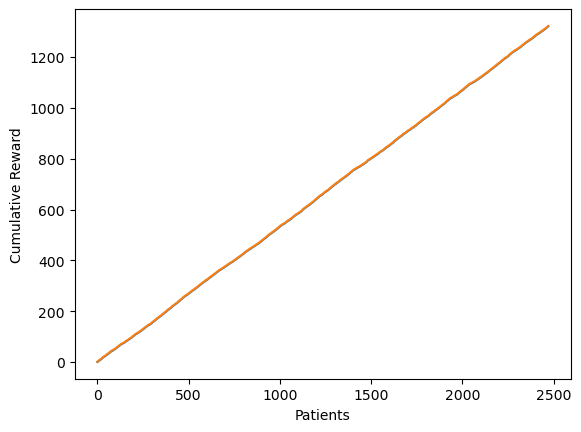

In [11]:
import matplotlib.pyplot as plt

plt.plot(results['NeuralUCB']['cumulative_rewards'])
plt.plot(results['LinUCB']['cumulative_rewards'])
plt.gca().set_ylabel('Cumulative Reward')
plt.gca().set_xlabel('Patients')
plt.show()